In [3]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


#!pip install beautifulsoup4
from bs4 import BeautifulSoup

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
#!pip install folium
import folium # map rendering library

# use the inline backend to generate the plots within the browser
%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('ggplot') # optional: for ggplot-like style

# check for latest version of Matplotlib
print ('Matplotlib version: ', mpl.__version__) # >= 2.0.0

print('Libraries imported.')

Matplotlib version:  3.0.2
Libraries imported.


In [4]:
!wget -q -O 'Bogota.html' https://worldpostalcode.com/colombia/bogota/d-c
print('Data downloaded!')

with open("Bogota.html", "r", encoding='utf-8') as f:
    text= f.read()

Data downloaded!


In [5]:
Bogota = BeautifulSoup(text, 'html.parser')

#print(Bogota.prettify())

In [4]:
column_names = ['Neighborhood','Postalcode']
df = pd.DataFrame(columns = column_names)

In [5]:
for tr_cell in Bogota.find_all(class_='container'): 
    row_data = []
    for td_cell in tr_cell.find_all('div'):
        row_data.append(td_cell.text.strip())
    if len(row_data)==2:
        df.loc[len(df)] = row_data

In [7]:
print(df.size)
df.loc[82,'Postalcode']

536


'111011 111031'

In [8]:
row_data = []
for n in range(len(df)):    
    s = df['Postalcode'].iloc[n][0:6]
    row_data.append(s)  
#row_data

In [9]:
df['Postalcode'] = row_data
df.loc[82,'Postalcode']  

'111011'

In [10]:
temp_df=df.groupby('Postalcode')['Neighborhood'].apply(lambda x: ', '.join(x.astype(str))).reset_index(drop=False)
temp_df.rename(columns={'Neighborhood':'Neighborhood_joined'},inplace=True)
temp_df.head(10)

,Postalcode,Neighborhood_joined
0,110121,"Acacias Usaquen, Bella Suiza, Bosque De Pinos ..."
1,110131,"Barrancas, Barrancas Norte, Barrancas Oriental..."
2,110141,"Buenavista, Canaima, El Cerezo"
3,110221,"Antiguo Country, Bellavista, Chico Norte, Chic..."
4,110231,"Bosque Calderon, Cataluna, Chapinero Central, ..."
5,110311,Bosque Izquierdo
6,110411,"Aguas Claras, Buenos Aires, Calvo Sur"
7,110421,"Atenas Sur, Bello Horizonte, Cordoba"
8,110431,"Altamira, Altos Del Poblado, Altos Del Zipa, A..."
9,110441,"Canada O Guira, Chiguaza, Ciudad Londres I"


In [11]:
def get_geocode(df,postal_code,geolocator):
    location = None
    location = geolocator.geocode(df[postal_code])
    if location:
        latitude = location.latitude
        longitude = location.longitude
    else :
        latitude = None
        longitude = None
    return latitude,longitude

In [12]:
geolocator = Nominatim(user_agent="bog_explorer")

#Latitude = temp_df.apply(get_geocode, axis=1, postal_code='Postalcode', geolocator=geolocator)

temp_df['Lat'], temp_df['Long'] = zip(*temp_df.apply(get_geocode, axis=1, postal_code='Postalcode', geolocator=geolocator))

In [13]:
temp_df.head(10)

,Postalcode,Neighborhood_joined,Lat,Long
0,110121,"Acacias Usaquen, Bella Suiza, Bosque De Pinos ...",4.71459,-74.0333
1,110131,"Barrancas, Barrancas Norte, Barrancas Oriental...",4.73248,-74.0289
2,110141,"Buenavista, Canaima, El Cerezo",-7.99787,-34.9251
3,110221,"Antiguo Country, Bellavista, Chico Norte, Chic...",4.67203,-74.0543
4,110231,"Bosque Calderon, Cataluna, Chapinero Central, ...",4.64322,-74.0565
5,110311,Bosque Izquierdo,4.61007,-74.0698
6,110411,"Aguas Claras, Buenos Aires, Calvo Sur",12.2958,121.382
7,110421,"Atenas Sur, Bello Horizonte, Cordoba",4.56588,-74.089
8,110431,"Altamira, Altos Del Poblado, Altos Del Zipa, A...",12.9716,121.445
9,110441,"Canada O Guira, Chiguaza, Ciudad Londres I",4.5279,-74.0873


In [14]:
geo_data = temp_df[ np.logical_and(temp_df['Lat']> 4, temp_df['Lat']< 5)]
column_names = ['Postalcode', 'Neighborhood','Lat','Long']
geo_data.columns = column_names
geo_data.head()

,Postalcode,Neighborhood,Lat,Long
0,110121,"Acacias Usaquen, Bella Suiza, Bosque De Pinos ...",4.71459,-74.0333
1,110131,"Barrancas, Barrancas Norte, Barrancas Oriental...",4.73248,-74.0289
3,110221,"Antiguo Country, Bellavista, Chico Norte, Chic...",4.67203,-74.0543
4,110231,"Bosque Calderon, Cataluna, Chapinero Central, ...",4.64322,-74.0565
5,110311,Bosque Izquierdo,4.61007,-74.0698


In [15]:
CLIENT_ID = 'WZVHRDQ3YI3JW4F12MOE2TQPHZ4I5BITKZY1BTIQXP0E21BL' # your Foursquare ID
CLIENT_SECRET = 'FJ4DDCXRWUQ2WWMDW3YTFRU4IRPXENZ2UYNV53HBUUWLGWS1' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: WZVHRDQ3YI3JW4F12MOE2TQPHZ4I5BITKZY1BTIQXP0E21BL
CLIENT_SECRET:FJ4DDCXRWUQ2WWMDW3YTFRU4IRPXENZ2UYNV53HBUUWLGWS1


In [16]:
def getNearbyVenues(names, latitudes, longitudes):
    radius=500
    LIMIT=100
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [17]:
bogota_venues = getNearbyVenues(names = geo_data['Neighborhood'],
                                   latitudes = geo_data['Lat'],
                                   longitudes = geo_data['Long']
                                  )

Acacias Usaquen, Bella Suiza, Bosque De Pinos I, Cedritos, Cedro Narvaez, Country Club
Barrancas, Barrancas Norte, Barrancas Oriental, Bosque De Pinos, Bosque De Pinos Iii, Caobos Salazar, Cedro Salazar
Antiguo Country, Bellavista, Chico Norte, Chico Norte Ii Sector, Chico Norte Iii Sector, El Bagazal
Bosque Calderon, Cataluna, Chapinero Central, Chapinero Norte
Bosque Izquierdo
Atenas Sur, Bello Horizonte, Cordoba
Canada O Guira, Chiguaza, Ciudad Londres I
Brisas Del Llano, Chapinerito, El Bosque, El Bosque Central, El Bosque Central I, El Bosque Sur Oriental, El Bosque Sur Oriental Rural I
Antonio Jose De Sucre, Centro Usme, Centro Usme Rural, Centro Usme Rural I, Centro Usme Rural Ii, Centro Usme Urbano, Charala, Chuniza, Comuneros, Desarrollo Brazuelos, Desarrollo Brazuelos I
Betania, Brasil, Brasilia, Canaveralejo, Canaveralejo Rural, Chicala
Bosa Nova, Bosa Nova El Porvenir, Chico Sur, Ciudadela El Recreo I, Ciudadela El Recreo Ii
Antonia Santos, Argelia Ii, Bosa
Andalucia Ii, Ce

In [18]:
bogota_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Acacias Usaquen, Bella Suiza, Bosque De Pinos ...",4.714588,-74.033309,Tropa Bogota,4.713327,-74.033333,Gym / Fitness Center
1,"Acacias Usaquen, Bella Suiza, Bosque De Pinos ...",4.714588,-74.033309,Surtifruver,4.715222,-74.032286,Health Food Store
2,"Acacias Usaquen, Bella Suiza, Bosque De Pinos ...",4.714588,-74.033309,Parque Lisboa,4.713853,-74.032753,Basketball Court
3,"Acacias Usaquen, Bella Suiza, Bosque De Pinos ...",4.714588,-74.033309,Café Oma Éxito Country,4.712767,-74.034266,Café
4,"Acacias Usaquen, Bella Suiza, Bosque De Pinos ...",4.714588,-74.033309,Salida #Allianz15K,4.714462,-74.033004,Athletics & Sports


In [19]:
bogota_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Acacias Usaquen, Bella Suiza, Bosque De Pinos I, Cedritos, Cedro Narvaez, Country Club",55,55,55,55,55,55
"Acevedo Tejada, Campin Occidental, Campo Eucaristico, Centro Administrativo Occ, Centro Narino, Ciudad Salitre Nororiental, Ciudad Salitre Suroriental, Ciudad Universitaria",4,4,4,4,4,4
"Aeropuerto El Dorado, Atahualpa, Brisas Aldea Fontibon, Charco Rural",20,20,20,20,20,20
Alamos,4,4,4,4,4,4
"Alcazares Norte, Doce De Octubre",13,13,13,13,13,13
"Alcazares, Baquero, Benjamin Herrera, Colombia, Concepcion Norte",17,17,17,17,17,17
"Alfonso Lopez, Armenia, Banco Central, Belalcazar, Campin, Chapinero Occidental",11,11,11,11,11,11
"Almirante Colon, Altos De Chozica, Andes Norte, Ciudad Hunza, Club De Los Lagartos",22,22,22,22,22,22
"Alqueria La Fragua, Alqueria La Fragua Norte, Boita",7,7,7,7,7,7


In [20]:
# one hot encoding
bogota_onehot = pd.get_dummies(bogota_venues[['Venue Category']], prefix="", prefix_sep="")
#bogota_onehot.drop(['Neighborhood'],axis=1,inplace=True) 
bogota_onehot.insert(loc=0, column='Neighborhood', value=bogota_venues['Neighborhood'] )
bogota_onehot.shape

(568, 147)

In [21]:
bogota_grouped = bogota_onehot.groupby('Neighborhood').mean().reset_index()
bogota_grouped.head()

,Neighborhood,ATM,American Restaurant,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Asian Restaurant,Athletics & Sports,BBQ Joint,Bakery,Bar,Basketball Court,Bed & Breakfast,Big Box Store,Bistro,Bookstore,Botanical Garden,Bowling Alley,Breakfast Spot,Brewery,Building,Burger Joint,Bus Station,Café,Candy Store,Caribbean Restaurant,Casino,Clothing Store,Cocktail Bar,Coffee Shop,Comfort Food Restaurant,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Cultural Center,Cupcake Shop,Deli / Bodega,Department Store,Dessert Shop,Discount Store,Donut Shop,Drugstore,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Service,Fabric Shop,Farm,Farmers Market,Fast Food Restaurant,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gas Station,Gastropub,German Restaurant,Gift Shop,Grocery Store,Gym,Gym / Fitness Center,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Home Service,Hostel,Hot Dog Joint,Hotel,Ice Cream Shop,Indian Restaurant,Indie Theater,Irish Pub,Italian Restaurant,Japanese Restaurant,Juice Bar,Karaoke Bar,Lake,Latin American Restaurant,Market,Martial Arts Dojo,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Motorcycle Shop,Movie Theater,Multiplex,Music Store,Music Venue,Nightclub,Notary,Paella Restaurant,Park,Pastry Shop,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pharmacy,Pizza Place,Planetarium,Playground,Plaza,Pool,Pub,Record Shop,Recording Studio,Recreation Center,Restaurant,Salad Place,Sandwich Place,Seafood Restaurant,Shipping Store,Shopping Mall,Smoothie Shop,Snack Place,Soccer Field,Soccer Stadium,Soup Place,South American Restaurant,Speakeasy,Sporting Goods Shop,Stables,Steakhouse,Supermarket,Sushi Restaurant,Tapas Restaurant,Tea Room,Theater,Theme Park,Toy / Game Store,Trade School,Vegetarian / Vegan Restaurant,Warehouse Store,Whisky Bar,Wings Joint,Women's Store,Yoga Studio
0,"Acacias Usaquen, Bella Suiza, Bosque De Pinos ...",0.018182,0.018182,0.0,0.018182,0.0,0.0,0.0,0.018182,0.018182,0.00,0.036364,0.036364,0.018182,0.00,0.018182,0.0,0.018182,0.0,0.0,0.0,0.0,0.0,0.054545,0.0,0.018182,0.0,0.00,0.018182,0.0,0.0,0.018182,0.0,0.0,0.0,0.0,0.018182,0.0,0.0,0.000000,0.018182,0.0,0.0,0.0,0.018182,0.0,0.0,0.0,0.0,0.018182,0.0,0.0,0.127273,0.018182,0.0,0.0,0.0,0.018182,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.018182,0.018182,0.0,0.018182,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.036364,0.0,0.0,0.0,0.00,0.018182,0.00,0.0,0.0,0.018182,0.018182,0.0,0.018182,0.0,0.018182,0.0,0.018182,0.000000,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.036364,0.0,0.0,0.036364,0.0,0.0,0.0,0.0,0.0,0.036364,0.0,0.018182,0.0,0.0,0.036364,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.018182,0.018182,0.0,0.0,0.0,0.0,0.0,0.018182,0.0,0.000000,0.0,0.0,0.0,0.018182,0.0
1,"Acevedo Tejada, Campin Occidental, Campo Eucar...",0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.250000,0.0,0.000000,0.0,0.25,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.250000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00,0.000000,0.00,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.250000,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
2,"Aeropuerto El Dorado, Atahualpa, Brisas Aldea ...",0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.05,0.150000,0.050000,0.000000,0.05,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.050000,0.0,0.000000,0

In [22]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [23]:
num_top_venues = 4

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = bogota_grouped['Neighborhood']

for ind in np.arange(bogota_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(bogota_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue
0,"Acacias Usaquen, Bella Suiza, Bosque De Pinos ...",Fast Food Restaurant,Burger Joint,Bakery,Restaurant
1,"Acevedo Tejada, Campin Occidental, Campo Eucar...",Burger Joint,Gym,Music Venue,Caribbean Restaurant
2,"Aeropuerto El Dorado, Atahualpa, Brisas Aldea ...",Hotel,Bakery,Pizza Place,Restaurant
3,Alamos,Department Store,Fast Food Restaurant,Lake,Mexican Restaurant
4,"Alcazares Norte, Doce De Octubre",Deli / Bodega,German Restaurant,Fast Food Restaurant,Music Venue


## 4. Cluster Neighborhoods


In [24]:
# set number of clusters
kclusters = 10

bogota_grouped_clustering = bogota_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(bogota_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:40]

array([1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 5, 4, 1, 2, 1, 1, 8, 1, 1, 1, 1,
       1, 1, 3, 6, 1, 0, 1, 1, 1, 1, 1, 7, 2, 1, 9, 1, 6, 1], dtype=int32)

In [25]:
# add clustering labels

neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

bogota_merged = geo_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
#toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
bogota_merged = pd.merge(bogota_merged,neighborhoods_venues_sorted,on='Neighborhood')

bogota_merged.head()

,Postalcode,Neighborhood,Lat,Long,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue
0,110121,"Acacias Usaquen, Bella Suiza, Bosque De Pinos ...",4.71459,-74.0333,1,Fast Food Restaurant,Burger Joint,Bakery,Restaurant
1,110131,"Barrancas, Barrancas Norte, Barrancas Oriental...",4.73248,-74.0289,1,Restaurant,Gym / Fitness Center,Coffee Shop,Donut Shop
2,110221,"Antiguo Country, Bellavista, Chico Norte, Chic...",4.67203,-74.0543,1,Hotel,Italian Restaurant,Restaurant,Coffee Shop
3,110231,"Bosque Calderon, Cataluna, Chapinero Central, ...",4.64322,-74.0565,1,Hot Dog Joint,Vegetarian / Vegan Restaurant,Café,Comfort Food Restaurant
4,110311,Bosque Izquierdo,4.61007,-74.0698,1,Sandwich Place,Café,Restaurant,Breakfast Spot


In [26]:
address = 'Bogota, co '

geolocator = Nominatim(user_agent="bog_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Bogota are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Bogota are 4.59808, -74.0760439.


In [27]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(bogota_merged['Lat'], bogota_merged['Long'], bogota_merged['Neighborhood'], bogota_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [28]:
bogota_merged.loc[bogota_merged['Cluster Labels'] == 0, bogota_merged.columns[[1] + list(range(5, bogota_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue
10,"Bosa Nova, Bosa Nova El Porvenir, Chico Sur, C...",Department Store,Grocery Store,Yoga Studio,Electronics Store
21,Alamos,Department Store,Fast Food Restaurant,Lake,Mexican Restaurant


In [29]:
bogota_merged.loc[bogota_merged['Cluster Labels'] == 1, bogota_merged.columns[[1] + list(range(5, bogota_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue
0,"Acacias Usaquen, Bella Suiza, Bosque De Pinos ...",Fast Food Restaurant,Burger Joint,Bakery,Restaurant
1,"Barrancas, Barrancas Norte, Barrancas Oriental...",Restaurant,Gym / Fitness Center,Coffee Shop,Donut Shop
2,"Antiguo Country, Bellavista, Chico Norte, Chic...",Hotel,Italian Restaurant,Restaurant,Coffee Shop
3,"Bosque Calderon, Cataluna, Chapinero Central, ...",Hot Dog Joint,Vegetarian / Vegan Restaurant,Café,Comfort Food Restaurant
4,Bosque Izquierdo,Sandwich Place,Café,Restaurant,Breakfast Spot
5,"Atenas Sur, Bello Horizonte, Cordoba",Playground,Construction & Landscaping,Bar,Electronics Store
7,"Brisas Del Llano, Chapinerito, El Bosque, El B...",Fast Food Restaurant,Discount Store,Coffee Shop,Yoga Studio
12,Cooperativa De Suboficiales,Fast Food Restaurant,Sandwich Place,Coffee Shop,Department Store
13,"Alqueria La Fragua, Alqueria La Fragua Norte, ...",Restaurant,BBQ Joint,South American Restaurant,Park
14,"Ciudad De Cali, Dindalito",Fast Food Restaurant,Construction & Landscaping,Restaurant,Eastern European Restaurant


In [30]:
bogota_merged.loc[bogota_merged['Cluster Labels'] == 2, bogota_merged.columns[[1] + list(range(5, bogota_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue
26,Aures Ii,Pizza Place,Shipping Store,Electronics Store,Fast Food Restaurant
35,"Caracas, Ciudad Berna, Ciudad Jardin Sur, Edua...",Pizza Place,Mexican Restaurant,Mobile Phone Shop,Farmers Market


In [31]:
bogota_merged.loc[bogota_merged['Cluster Labels'] == 3, bogota_merged.columns[[1] + list(range(5, bogota_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue
27,"Berlin, Bilbao",Park,Supermarket,Yoga Studio,Electronics Store


In [32]:
bogota_merged.loc[bogota_merged['Cluster Labels'] == 4, bogota_merged.columns[[1] + list(range(5, bogota_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue
8,"Antonio Jose De Sucre, Centro Usme, Centro Usm...",Bus Station,Gas Station,Pool,Yoga Studio


In [33]:
bogota_merged.loc[bogota_merged['Cluster Labels'] == 5, bogota_merged.columns[[1] + list(range(5, bogota_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue
11,"Antonia Santos, Argelia Ii, Bosa",Home Service,Pharmacy,Electronics Store,Fast Food Restaurant


In [34]:
bogota_merged.loc[bogota_merged['Cluster Labels'] == 6, bogota_merged.columns[[1] + list(range(5, bogota_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue
9,"Betania, Brasil, Brasilia, Canaveralejo, Canav...",Movie Theater,Shopping Mall,Yoga Studio,Flea Market
34,"Colseguros, Eduardo Santos",Shopping Mall,Mobile Phone Shop,Department Store,Clothing Store


In [35]:
bogota_merged.loc[bogota_merged['Cluster Labels'] == 7, bogota_merged.columns[[1] + list(range(5, bogota_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue
6,"Canada O Guira, Chiguaza, Ciudad Londres I",Flower Shop,BBQ Joint,Flea Market,Fast Food Restaurant


In [36]:
bogota_merged.loc[bogota_merged['Cluster Labels'] == 8, bogota_merged.columns[[1] + list(range(5, bogota_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue
36,"Barcelona, Batallon Caldas, Centro Industrial,...",Soccer Stadium,Soccer Field,Clothing Store,Electronics Store


In [37]:
bogota_merged.loc[bogota_merged['Cluster Labels'] == 9, bogota_merged.columns[[1] + list(range(5, bogota_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue
20,"Centro Engativa Ii, El Cedro",Burger Joint,Lake,Yoga Studio,Ethiopian Restaurant


In [38]:
fmost = bogota_merged.groupby('1st Most Common Venue').count()
fmost[['Postalcode']]

,Postalcode
1st Most Common Venue,
BBQ Joint,1
Bar,1
Bowling Alley,1
Burger Joint,2
Bus Station,2
Café,1
Cocktail Bar,1
Coffee Shop,2
Deli / Bodega,1


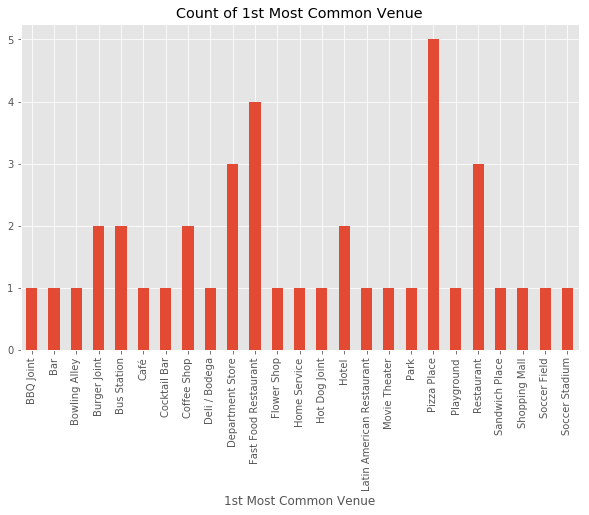

In [39]:
fmost['Postalcode'].plot(kind='bar', figsize=(10, 6))
plt.xlabel('1st Most Common Venue') # add to x-label to the plot
plt.ylabel('') # add y-label to the plot
plt.title('Count of 1st Most Common Venue') # add title to the plot
plt.show()

In [40]:
fmost = bogota_merged.groupby('2nd Most Common Venue').count()
fmost[['Postalcode']]

,Postalcode
2nd Most Common Venue,
Art Museum,1
BBQ Joint,3
Bakery,3
Burger Joint,1
Café,1
Construction & Landscaping,2
Deli / Bodega,1
Department Store,1
Discount Store,1


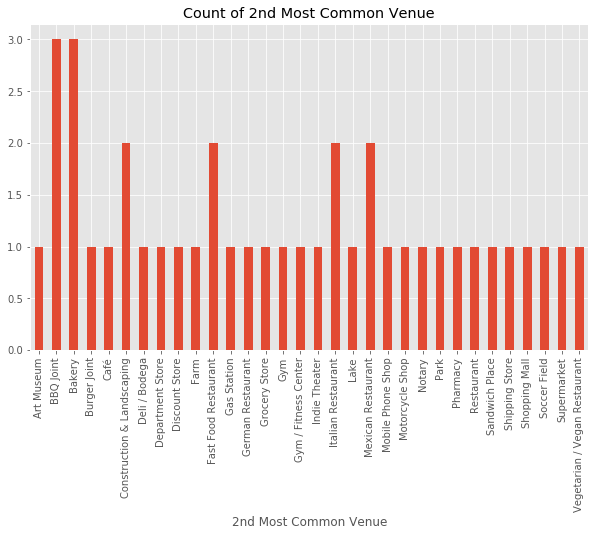

In [41]:
fmost['Postalcode'].plot(kind='bar', figsize=(10, 6))
plt.xlabel('2nd Most Common Venue') # add to x-label to the plot
plt.ylabel('') # add y-label to the plot
plt.title('Count of 2nd Most Common Venue') # add title to the plot
plt.show()

In [42]:
fmost = bogota_merged.groupby('3rd Most Common Venue').count()
fmost[['Postalcode']]

,Postalcode
3rd Most Common Venue,
Arcade,1
BBQ Joint,1
Bakery,2
Bar,1
Café,2
Clothing Store,1
Coffee Shop,3
Concert Hall,1
Convenience Store,1


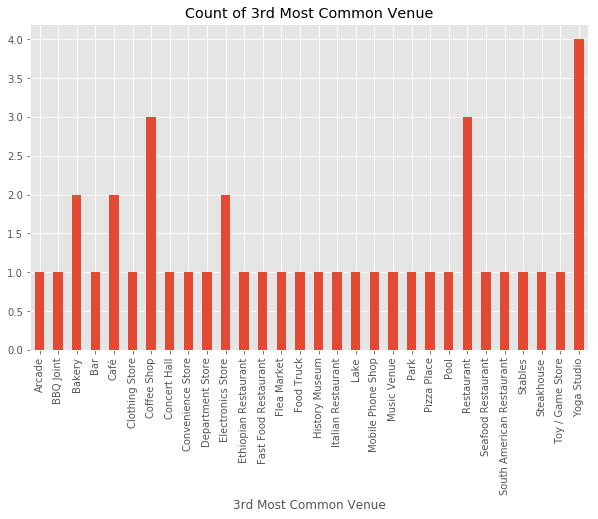

In [43]:
fmost['Postalcode'].plot(kind='bar', figsize=(10, 6))
plt.xlabel('3rd Most Common Venue') # add to x-label to the plot
plt.ylabel('') # add y-label to the plot
plt.title('Count of 3rd Most Common Venue') # add title to the plot
plt.show()

In [44]:
fmost = bogota_merged.groupby('4th Most Common Venue').count()
fmost[['Postalcode']]

,Postalcode
4th Most Common Venue,
Bowling Alley,1
Breakfast Spot,1
Caribbean Restaurant,1
Clothing Store,1
Cocktail Bar,1
Coffee Shop,2
Comfort Food Restaurant,1
Convenience Store,1
Department Store,1


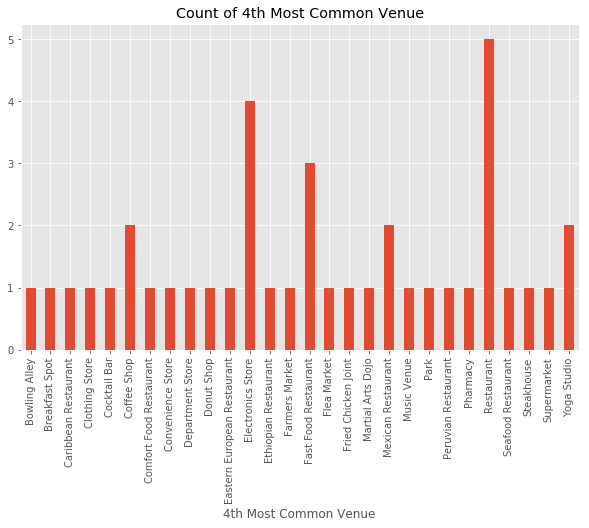

In [45]:
fmost['Postalcode'].plot(kind='bar', figsize=(10, 6))
plt.xlabel('4th Most Common Venue') # add to x-label to the plot
plt.ylabel('') # add y-label to the plot
plt.title('Count of 4th Most Common Venue') # add title to the plot
plt.show()